# Retrieve Images in new Grids and Sampling

### Fei Zhang @Geoscience Australia

August 2016

## Introduction

Datacube APIs to retrieve gridded data (images), and output in new CRS and samplings - as long as the CRS is supported by python GDAL lib. 

### Related Topics: 

1) Userguide how to index a dataset (like DSM) make it recognised by datacube ?

2) How to export proper geotiff (and netcdf) files from the new images?

## Interactive Computing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import pandas

import sys
sys.path.insert(0, '/g/data/u46/fxz547/Githubz/agdc-v2')#'/home/547/fxz547/myGithub/agdc-v2')  #prepend a path

In [2]:
# import AGDC Python API modules

import datacube
from datacube.storage import masking

# Create an API data access object
dc = datacube.Datacube(app='GetData')

dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://fxz547@130.56.244.227:6432/datacube)>>>

We can access the Postgres Database (metadata index) and its associated imagery data.

## Datacube Products List 
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [3]:
df_prodlist = dc.list_products()

df_prodlist.shape

(32, 15)

In [4]:
df_prodlist.head()

,name,description,product_type,sat_path,format,lon,platform,sat_row,instrument,time,lat,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
36,bom_rainfall_grids,Interpolated Rain Gauge Precipitation 1-Day Au...,rainfall,NaN,NETCDF,NaN,BoM,NaN,rain gauge,None,NaN,EPSG:4326,"[-0.05, 0.05]",None,"(latitude, longitude)"
32,dsm1sv10,DSM 1sec Version 1.0,DEM,NaN,ENVI,NaN,SRTM,NaN,SIR,None,NaN,EPSG:4326,"[-0.00027777777778, 0.00027777777778]",None,"(latitude, longitude)"
27,ls5_fc_albers,"Landsat 5 Fractional Cover 25 metre, 100km til...",fractional_cover,NaN,NetCDF,NaN,LANDSAT_5,NaN,TM,None,NaN,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"
2,ls5_level1_scene,Landsat 5 Level 1 At-sensor Radiance 25 metre,level1,NaN,GeoTiff,NaN,LANDSAT_5,NaN,TM,None,NaN,NaN,NaN,NaN,NaN
6,ls5_nbar_albers,"Landsat 5 Surface Reflectance NBAR 25 metre, 1...",nbar,NaN,NetCDF,NaN,LANDSAT_5,NaN,TM,None,NaN,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"


## Measurements List of the Products

- Each of the datacube products may have multiple measurements.

- Measurements are related to the sensors characteristics,  also known as _bands_ in the remote-sensing domain.

- _bands_ comes from electromagnetic wave spectral ranges, generally include Red-Green-Blue (RGB). 

In [5]:
df_measlist = dc.list_measurements()

df_measlist.shape

(99, 7)

In [6]:
df_measlist.head(2)

,,aliases,dtype,flags_definition,name,nodata,spectral_definition,units
product,measurement,,,,,,,
bom_rainfall_grids,rainfall,NaN,float32,NaN,rainfall,-999,NaN,mm
dsm1sv10,elevation,NaN,float32,NaN,elevation,NaN,NaN,metre


## Retrieving data


In [7]:
#To see the function signature?
#dc.load?

# Where?
xp=(149.07, 149.17); yp=(-35.25, -35.35)  # Lake Burley Griffin x=(149.07, 149.17), y=(-35.25, -35.35), 
# xp=( 149.160,  149.170); yp=(-35.34 , -35.35 )  #a small area cover GA water pond
                
# When? a time range
tp=('2015-01', '2015-12-31')

# output grid and associated resolution
v_output_crs='EPSG:3112'; v_resolution=(-25,25)  #LCC

In [8]:

nbar = dc.load(product='ls8_nbar_albers', x=xp, y=yp, time=tp, output_crs=v_output_crs, resolution=v_resolution)


The returned data is an `xarray.Dataset` object, which is a labelled n-dimensional array wrapping a `numpy` array.

We can investigate the data to see the variables (measurement bands) and dimensions that were returned:

In [9]:
nbar

<xarray.Dataset>
Dimensions:          (time: 63, x: 414, y: 484)
Coordinates:
  * time             (time) datetime64[ns] 2015-01-02T23:50:19.500000 ...
  * y                (y) float64 -4.049e+06 -4.049e+06 -4.049e+06 -4.049e+06 ...
  * x                (x) float64 1.364e+06 1.364e+06 1.364e+06 1.364e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) int16 508 538 663 648 642 553 680 755 575 ...
    blue             (time, y, x) int16 481 527 656 629 620 543 686 748 545 ...
    green            (time, y, x) int16 722 774 913 826 892 788 909 953 758 ...
    red              (time, y, x) int16 908 1082 1132 936 929 917 1131 1256 ...
    nir              (time, y, x) int16 2442 2465 2449 2304 2624 2810 2797 ...
    swir1            (time, y, x) int16 2682 2924 2385 1976 2101 2081 2447 ...
    swir2            (time, y, x) int16 1643 1948 1817 1409 1423 1424 1828 ...
Attributes:
    crs: EPSG:3112

We can look at the data by name directly, or through the `data_vars` dictionary:

In [10]:
nbar.data_vars

Data variables:
    coastal_aerosol  (time, y, x) int16 508 538 663 648 642 553 680 755 575 ...
    blue             (time, y, x) int16 481 527 656 629 620 543 686 748 545 ...
    green            (time, y, x) int16 722 774 913 826 892 788 909 953 758 ...
    red              (time, y, x) int16 908 1082 1132 936 929 917 1131 1256 ...
    nir              (time, y, x) int16 2442 2465 2449 2304 2624 2810 2797 ...
    swir1            (time, y, x) int16 2682 2924 2385 1976 2101 2081 2447 ...
    swir2            (time, y, x) int16 1643 1948 1817 1409 1423 1424 1828 ...

In [11]:
nbar.green

<xarray.DataArray 'green' (time: 63, y: 484, x: 414)>
array([[[ 722,  774,  913, ...,  814,  812,  821],
        [ 669,  734, 1040, ...,  749,  744,  783],
        [ 683,  748,  854, ...,  757,  717,  753],
        ..., 
        [ 576,  541,  550, ...,  868,  853,  796],
        [ 565,  597,  608, ...,  852,  857,  820],
        [ 519,  615,  541, ...,  831,  823,  803]],

       [[ 722,  770,  925, ...,  811,  810,  822],
        [ 667,  744, 1031, ...,  748,  744,  783],
        [ 695,  756,  841, ...,  764,  722,  755],
        ..., 
        [ 582,  552,  562, ...,  869,  854,  800],
        [ 576,  607,  614, ...,  852,  855,  822],
        [ 528,  618,  543, ...,  833,  823,  805]],

       [[2606, 2634, 2676, ..., 2478, 2471, 2457],
        [2581, 2605, 2666, ..., 2453, 2439, 2419],
        [2578, 2594, 2641, ..., 2442, 2439, 2421],
        ..., 
        [3507, 3535, 3479, ..., -999, -999, -999],
        [3597, 3570, 3515, ..., -999, -999, -999],
        [3658, 3609, 3552, ..., -

In [12]:
print(nbar.red.shape)
print(nbar.green.shape)
print(nbar.blue.shape)
print(nbar.swir1.shape)  # short wave Length Infrared sensor

(63, 484, 414)
(63, 484, 414)
(63, 484, 414)
(63, 484, 414)


In [13]:
print(nbar.time.min())

print(nbar.time.max())


<xarray.DataArray 'time' ()>
numpy.datetime64('2015-01-03T10:50:19.500000000+1100')
<xarray.DataArray 'time' ()>
numpy.datetime64('2015-11-26T10:56:37.500000000+1100')


## Create and Display a multi-band image

###  select a time-slice of the imagery stack
###  use pandas-style slicing to select a time period

In [14]:
itime=1

def show_images(nbar, itime):
    
    print ("Showing images acquired in datetime ", nbar.time.values[itime])
    
    red_img=nbar.red.isel(time=itime)
    green_img=nbar.green.isel(time=itime)
    blue_img = nbar.blue.isel(time=itime)


    plt.figure( figsize=(16,14) )
    
    plt.subplot( 1,3,1 )
    plt.imshow(red_img)#, cmap='gray')
    plt.title("Red band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='red sensor measurement');

    
    plt.subplot( 1,3,2 )
    plt.imshow(green_img)   # plotting the subset data directly
    #plt.imshow(green_img, cmap='gray')
    plt.title("Green band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='green sensor measurement');


    plt.subplot( 1,3,3 )
    plt.imshow(blue_img)   # plotting the subset data directly
    #plt.imshow(blue_img, cmap='gray')
    plt.title("Blue band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='blue sensor measurement');

    return


('Showing images acquired in datetime ', numpy.datetime64('2015-01-03T10:50:43.500000000+1100'))


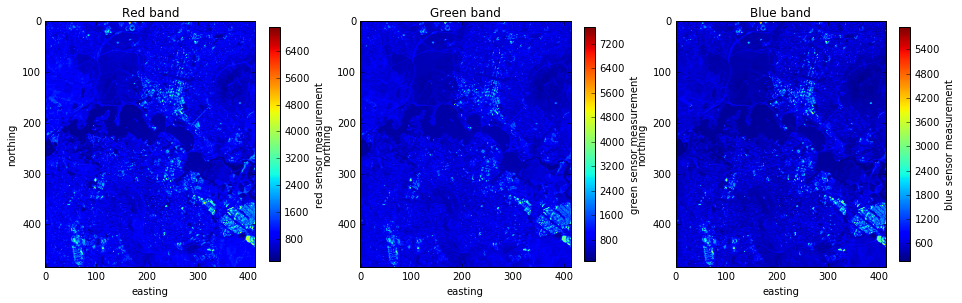

In [15]:
# show the images of bands at itime=0,1, 10

show_images(nbar, 1)

Each band is a grayscale image. They can be combined to make a better image.

In [16]:
# define a scale function to strech an image 

def scale_array(arr, prcnt, min_val, max_val, nan_val):
    """
    Linearly scales array 'arr' at the 'prcnt' percentile between 'min_val' and 'max_val', 
    replacing 'nan_val' values with NaN's.
    #f_arr = 1.0*arr #.astype('float')    # required for NaN's 
    """
  
    f_arr = arr.astype('float')
    #f_arr[f_arr==nan_val] = np.nan
    prcnt_delta = (100-prcnt)/2
    clip_lim = np.nanpercentile(f_arr,(prcnt_delta,100-prcnt_delta))
    f_arr = np.clip(f_arr,clip_lim[0],clip_lim[1])
    f_arr = (f_arr-clip_lim[0]) / (clip_lim[1]-clip_lim[0])
    f_arr = f_arr * (max_val-min_val) + min_val
    
    return f_arr


In [17]:
def make_rgb_images(nbar, itime):
    """
    Create a RGB image using bands acquired at itime
    """
    print ("RGB image acquired in datetime ", nbar.time.values[itime])
        
    red_img=nbar.red.isel(time=itime)
    green_img=nbar.green.isel(time=itime)
    blue_img = nbar.blue.isel(time=itime)


    plt.figure( figsize=(10,10) )
    
    red_img=nbar.red.isel(time=itime)
    green_img=nbar.green.isel(time=itime)
    blue_img = nbar.blue.isel(time=itime)
    y_size = red_img.shape[0]; x_size = red_img.shape[1]

    print (y_size,x_size)
    #print red_img.shape

    sB1data = scale_array(red_img, 99.0, 0, 255, -999)
    sB2data = scale_array(green_img, 99.0, 0, 255, -999)
    sB3data = scale_array(blue_img, 99.0, 0, 255, -999)


    rgb_image = np.zeros((y_size, x_size, 3), dtype='uint8')
    rgb_image[:,:,0] = sB1data; 
    rgb_image[:,:,1] = sB2data; 
    rgb_image[:,:,2] = sB3data

    plt.imshow(rgb_image, interpolation='none') 
    title_str= 'Landsat Image over the Area: %s, %s'% (str(xp), str(yp))
    plt.title(title_str)
    plt.ylabel('northing'); plt.xlabel('easting');

('RGB image acquired in datetime ', numpy.datetime64('2015-01-03T10:50:19.500000000+1100'))
(484, 414)


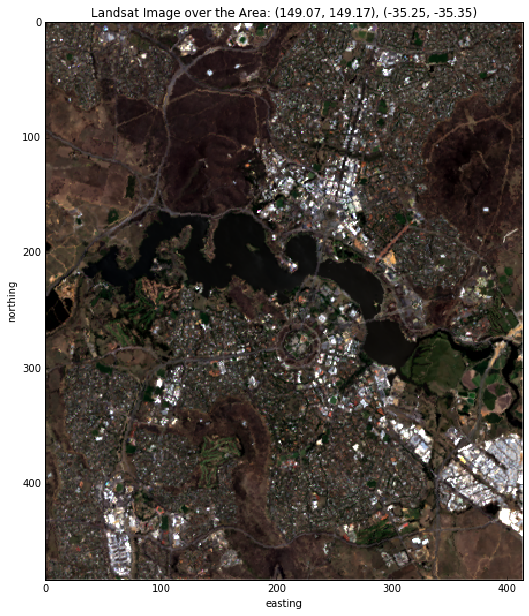

In [18]:
# good images: 3,4, 6
# cloudy images: itime=0,1
# no-data blank tiles: 2,5

make_rgb_images(nbar, 0)

# Export to geotiff raster file

In [19]:
import rasterio

DEFAULT_PROFILE = {
    'blockxsize': 256,
    'blockysize': 256,
    'compress': 'lzw',
    'driver': 'GTiff',
    'interleave': 'band',
    'nodata': 0.0,
    'photometric': 'RGBA',
    'tiled': True}


def write_geotiff(filename, dataset, time_index=None, profile_override=None):
    """
    Write an xarray dataset to a geotiff

    :attr bands: ordered list of dataset names
    :attr time_index: time index to write to file
    :attr dataset: xarray dataset containing multiple bands to write to file
    :attr profile_override: option dict, overrides rasterio file creation options.
    """
    profile_override = profile_override or {}

    dtypes = {val.dtype for val in dataset.data_vars.values()}
    assert len(dtypes) == 1  # Check for multiple dtypes

    profile = DEFAULT_PROFILE.copy()
    profile.update({
        'width': dataset.dims[dataset.crs.dimensions[1]],
        'height': dataset.dims[dataset.crs.dimensions[0]],
        'affine': dataset.affine,
        'crs': dataset.crs.crs_str,
        'count': len(dataset.data_vars),
        'dtype': str(dtypes.pop())
    })
    profile.update(profile_override)

    with rasterio.open(filename, 'w', **profile) as dest:
        for bandnum, data in enumerate(dataset.data_vars.values(), start=1):
            dest.write(data.isel(time=time_index).data, bandnum)

In [20]:
nbar.time.shape

stop

NameError: name 'stop' is not defined

In [ ]:
import os
for itime in xrange (0,1
ds=nbar
fname=str(ds.time.values[itime])[:19].replace(':','')
fname ="nbar%s.tiff"%fname
path2fname=os.path.join("/short/v10/fxz547/Dexport",fname)

write_geotiff(path2fname,ds, itime)

## Group  by solar day function

- There is a bit of overlap between two adjacent scenes ("cut").
- To remove the overlap duplication, we combine the data slices with datetimes less than a minute apart.  


In [ ]:
nbar_by_solar_day = dc.load(product='ls8_nbar_albers', x=xp, y=yp, time=tp, group_by='solar_day')
len(nbar_by_solar_day.time)

Now we have fewer timeslices than found previously without solar-day-grouping

According to Landsat cycle 16 days, 365/16 = 22 re-visit a place at least per year 

(For some region like Canberra, there will be overlap between passes)
Can be checked in the Clear Observation Layer at: http://eos-test.ga.gov.au/geoserver/www/remote_scripts/WOfS_v1.6.htm

In [ ]:
# show the images of bands at itime=0,1,2,3,4,... 10

show_images(nbar_by_solar_day, 0)

In [ ]:
nbar_by_solar_day

## Clear-sky images and cloudy images, we have to deal with in AGDC


In [ ]:
# 0, 5, 8 not cloudy
# 1,2,3,4 cloudy day
make_rgb_images(nbar_by_solar_day, 5 )

In [ ]:
# import os
itime=0
ds=nbar_by_solar_day
fname=str(nbar.time.values[itime])[:19].replace(':','')
fname ="nbarsolar%s.tiff"%fname
path2fname=os.path.join("/short/v10/fxz547/Dexport",fname)
write_geotiff(path2fname, ds, itime)

##  Applications based on AGDC

### Derive information products 
### Must identify and remove invalid observations: cloud, shadow, satuared pixels

### Band maths: combine the bands to derive new variables (artificial bands)

-  Normalized Difference Vegetation Index, NDVI
-  Normalized Difference Water Index,  NDWI
-  These index can help to clearly identify certain land cover features: Vegetation, water bodies

In [ ]:
#  from datacube.storage import masking

bands = dc.load(product='ls8_nbar_albers', x=xp, y=yp, time=tp, measurements=['red', 'nir', 'green', 'swir1'], 
                group_by='solar_day')
red = bands.red.where(bands.red != bands.red.attrs['nodata'])
nir = bands.nir.where(bands.nir != bands.nir.attrs['nodata'])
                    
green = bands.green.where(bands.green != bands.green.attrs['nodata'])
swir1 = bands.swir1.where(bands.swir1 != bands.swir1.attrs['nodata'])

# Retrieve the associated Pixel Quality datasets
pq = dc.load(product='ls8_pq_albers', x=xp, y=yp,  time=tp, group_by='solar_day') #, fuse_func='')

cloud_free = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality



### Compute Indexes: NDVI and NDWI

#### Numpy array arithmetics without looping

In [ ]:

# Normalized Differenc Vegetation Index: Red and near Infrared bands

ndvi = ((nir - red) / (nir + red)).where(cloud_free)

# Normalized Differenc Water Index: Green and Shortwave Infrared Bands

ndwi = ((swir1- green)/(green + swir1)).where(cloud_free)

#ndwi = ((green- swir1)/(green + swir1)).where(cloud_free)

ndvi.shape


In [ ]:
ndwi.shape

In [ ]:
# skip ndvi plots 
#ndvi.plot(col='time', col_wrap=6)

###  Weed out the low quality images.

In [ ]:
# xarray.Dataset.sum to reduce the datasets by selecting the time slices with high percentage cloud-free pixels

cloudfreeRatio = 0.9  # threshold of cloud pixel 80%

mostly_cloud_free = cloud_free.sum(dim=('x','y')) > (cloudfreeRatio * cloud_free.size / cloud_free.time.size)

print(mostly_cloud_free)

In [ ]:
# How many images selected?

mostly_cloud_free.sum().values

In [ ]:
# Apply the time-dim mask to the 3D-array (time, x, y)
mostly_good_ndvi = ndvi.where(mostly_cloud_free).dropna('time', how='all')
mostly_good_ndvi.plot(col='time', col_wrap=4)

In [ ]:
mostly_good_ndvi

In [ ]:
# import os
itime=0
ds= mostly_good_ndvi
fname=str(ds.time.values[itime])[:19].replace(':','')
fname ="ndvi%s.tiff"%fname
path2fname=os.path.join("/short/v10/fxz547/Dexport",fname)
write_geotiff(path2fname, ds, itime)

## Normalised Difference Water Index

In [ ]:
# images after removed invalid pixels. 
#ndwi.plot(col='time', col_wrap=6)


### Weed out the low quality images.

In [ ]:
# apply the cloud_threshold mask, which will select a subset images with good pixels. 

mostly_good_ndwi = ndwi.where(mostly_cloud_free).dropna('time', how='all')

mostly_good_ndwi.plot(col='time', col_wrap=5)

## Statistics Median and Mean Images

### Normalised Vegetation Index vs Water Index

In [ ]:
plt.figure( figsize=(16,12) )
    
plt.subplot( 2,2,1 )
mostly_good_ndvi.median(dim='time').plot()
plt.title("Median Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,2 )
mostly_good_ndvi.mean(dim='time').plot()
# ndvi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')

#------------------------------
plt.subplot( 2,2,3 )
mostly_good_ndwi.median(dim='time').plot()
plt.title("Median Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,4 )
mostly_good_ndwi.mean(dim='time').plot()
# ndwi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')

# Water Observation from Space

http://eos-test.ga.gov.au/geoserver/www/remote_scripts/WOfS_v1.6.htm


## DSM dataset indexed in DC

In [ ]:
grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.25, -35.35))
grid.elevation

In [ ]:
grid.elevation[0].plot()

## Re-projection and Re-sampling 

In [ ]:
# http://spatialreference.org/ref/epsg/gda94-geoscience-australia-lambert/ 3112
# EPSG:3577: GDA94 / Australian Albers
# EPSG:3112 GDA94 / Geoscience Australia Lambert

In [ ]:
albers_grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.25, -35.35), 
                      output_crs='EPSG:3577', resolution=(-25,25))

albers_grid.elevation.shape

In [ ]:
albers_grid.elevation[0].plot()

In [ ]:
lcc_grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.25, -35.35), 
                      output_crs='EPSG:3112', resolution=(-25,25))

lcc_grid.elevation.shape
lcc_grid.elevation[0].plot()

In [ ]:
geosphere_grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.35,-35.25),output_crs='EPSG:4326', resolution=(-0.00025, 0.00025))

geosphere_grid.elevation.shape


In [ ]:
query = {
    'lat': (-35.2, -35.4),
    'lon': (149.0, 149.2),
}

dsmgrid=dc.load(product='dsm1sv10', output_crs='EPSG:4326', resolution=(-0.00025, 0.00025), **query)

dsmgrid.elevation.shape

In [ ]:
dsmgrid.elevation[0].plot()

In [ ]:
#landsat = dc.load(product='ls5_nbar_albers', x=(149.25, 149.35),y=(-35.25, -35.35), time=('2011-01-01', '2011-03-01'), output_crs='EPSG:4326', resolution=(-0.00025, 0.00025))
landsat = dc.load(product='ls5_nbar_albers', x=(149.25, 149.35),y=(-35.25, -35.35), time=('2011-01-01', '2011-03-01'), output_crs='EPSG:4326', resolution=(-0.001, 0.001))

landsat.green[0].plot()

In [ ]:
landsat

In [ ]:
!getfacl /g/data/v10/projects/ingest_test_data/milestone1/dsm1sv1_0_Clean/